In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

import dask.dataframe as dd

In [ ]:
# Load video metadata

chunks_0 = []
chunks_1 = []
chunks_2 = []
chunks_3 = []
chunks_4 = []
chunks_5 = []
chunks_6 = []
chunks_7 = []
chunks_8 = []
chunks_9 = []
chunks_10 = []
chunks_11 = []
chunks_12 = []
chunks_13 = []


# Define the chunk size
chunk_size = 5000  # adjust based on memory availability

counter = 0

# Read the JSONL file in chunks
for chunk in tqdm(pd.read_json('YouNiverse\yt_metadata_en.jsonl.gz', lines=True, chunksize=chunk_size)):
    i = counter//1000
    globals()[f'chunks_{i}'].append(chunk)
    counter += 1


for i in tqdm(range(14)):
    name = f'df_video_meta_{i}'
    globals()[name] = pd.concat(globals()[f'chunks_{i}'], ignore_index=True)

# Concatenate all chunks into a single DataFrame after the loop
#df_video_meta = pd.concat(chunks, ignore_index=True)

0it [00:00, ?it/s]

In [ ]:
# Stopped running due to memory error
df_video_meta_dask = dd.read_json('YouNiverse/yt_metadata_en.jsonl.gz', lines=True)

MemoryError: An error occurred while calling the read_json method registered to the pandas backend.
Original Message: An error occurred while calling the read_json method registered to the pandas backend.
Original Message: 

In [3]:
# Define the chunk size (adjust based on memory availability)
chunk_size = 10000000

# Output Parquet file path (base name for individual files)
output_file_base = 'processed_data_chunk_'

# Initialize a counter for chunks
counter = 0

# Read the JSONL file in chunks
for chunk in tqdm(pd.read_json('YouNiverse/yt_metadata_en.jsonl.gz', lines=True, chunksize=chunk_size)):
    # Process each chunk as needed
    # Here you can apply any processing to the chunk

    # Save the chunk to a Parquet file
    chunk.to_parquet(f"{output_file_base}{counter}.parquet", index=False)

    # Increment the counter
    counter += 1
    print(f"Processed and saved chunk {counter}")

0it [00:00, ?it/s]

: 

In [ ]:
# First convert to parquet
import pyarrow.json as pj
import pyarrow.parquet as pq

# Read JSONL and convert to Parquet
input_file = "YouNiverse/yt_metadata_en.jsonl.gz"
output_file = "YouNiverse/yt_metadata.parquet"

table = pj.read_json(input_file)
pq.write_table(table, output_file)

# Now read the Parquet file with dask
import dask.dataframe as dd
df = dd.read_parquet(output_file)

# Ran for 37 min without success

In [1]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("LargeJSONProcessing").getOrCreate()

# Read the JSON file
df = spark.read.json("YouNiverse/yt_metadata_en.jsonl.gz")

# Convert to pandas DataFrame if necessary (or continue processing with Spark)
#pdf = filtered_df.toPandas()

RuntimeError: Java gateway process exited before sending its port number

In [2]:
import gzip
import json
from itertools import islice

# Define function to process a certain number of lines of the dataset
def process_jsonl_chunks(file_path, start_line=0, end_line=None, chunk_size=5000, output_parquet_file=None):
    """
    Reads a compressed JSON Lines file from a specific line range in chunks,
    processes each chunk, and optionally saves it to a Parquet file.

    Args:
        file_path (str): Path to the .jsonl.gz file.
        start_line (int): Line number to start reading from.
        end_line (int or None): Line number to stop reading at. If None, reads to the end.
        chunk_size (int): Number of lines per chunk.
        output_parquet_file (str): Path to save Parquet file. If None, does not save.

    Returns:
        None
    """
    
    with gzip.open(file_path, 'rt') as file:  # 'rt' for text mode with gzip
        # Skip to the start line
        print("Going to specified start line..")
        for _ in tqdm(range(start_line)):
            next(file)
        
        # Initialize a line counter
        current_line = start_line

        # Define dataframe to be returned
        df = []

        print("Getting chunks..")
        # Process the file in chunks until reaching end_line
        for i, chunk in enumerate(iter(lambda: list(islice(file, chunk_size)), [])):
            # Check if we're within the specified line range
            if end_line is not None and current_line >= end_line:
                break  # Stop if we've reached or exceeded the end line

            # Adjust the chunk size if it exceeds end_line
            if end_line is not None:
                chunk = chunk[: max(0, end_line - current_line)]
            
            # Convert the chunk to a DataFrame
            data = [json.loads(line) for line in chunk]
            df.append(pd.DataFrame(data))

            # Update current line
            current_line += len(chunk)
        
        print("Concatenating..")
        return pd.concat(df, ignore_index=True)

In [9]:
# Function to count lines of a JSON Lines file
def count_lines_in_chunks(file_path, chunk_size=100000):
    count = 0
    with gzip.open(file_path, 'rt') as file:
        while True:
            lines = file.readlines(chunk_size)  # Read a chunk of lines
            if not lines:
                break
            count += len(lines)
    return count

In [3]:
filepath = 'YouNiverse/yt_metadata_en.jsonl.gz'
#num_lines = count_lines_in_chunks(file_path=filepath)
#print(num_lines)
# There are as many lines as there are videos in the dataset

In [7]:
# End line is not included

# Loading data for first 20'000'000 videos
df_video_meta_1 = process_jsonl_chunks(file_path=filepath, start_line=0, end_line=20000000)

Going to specified start line..


0it [00:00, ?it/s]

Getting chunks..
Concatenating..


C:\Users\MaxLo\AppData\Local\Temp\ipykernel_26848\1242293564.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df, ignore_index=True)


In [8]:
df_video_meta_1.tail(5)
df_video_meta_1.to_parquet(path='YouNiverse/df_video_meta_1.gz', compression='gzip')

In [7]:
df_video_meta_1_parquet = pd.read_parquet(path='YouNiverse/df_video_meta_1.gz')

In [9]:
df_video_meta_1_parquet.tail()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
19999995,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:54.691949,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,8.0,jnfFTj85L8E,310,308.0,"02,Escape,From,The,Tavern,James,Horner",02 - Escape From The Tavern - James Horner - W...,2011-07-21 00:00:00,123004.0
19999996,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:55.296351,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,36.0,pRskpDvjrIM,590,1346.0,"01,Elora,Danan,James,Horner",01 - Elora Danan - James Horner - Willow,2011-07-21 00:00:00,308625.0
19999997,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:55.940956,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,2.0,SqggGvm_9a8,260,31.0,"14,See,You,James,Horner",14 - I See You - Leona Lewis - James Horner - ...,2011-06-23 00:00:00,3432.0
19999998,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:56.573328,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,0.0,Hjc5KhASGhI,680,21.0,"13,War,James,Horner",13 - War - James Horner - Avatar,2011-06-23 00:00:00,3590.0
19999999,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:57.067663,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,4.0,9j4OXdEJBpc,310,36.0,"12,Gathering,All,The,Na'vi,Clans,For,Battle,Ja...",12 - Gathering All The Na'vi Clans For Battle ...,2011-06-23 00:00:00,7562.0


In [10]:
df_video_meta_1.to_pickle(path='YouNiverse/df_video_meta_1_pickle.gz', compression='gzip')

In [ ]:
# Pickling and read pickle are slower than parqueting and read parquet -> preferably use parquet
df_video_meta_1_pickle = pd.read_pickle('YouNiverse/df_video_meta_1_pickle.gz')

In [6]:
df_video_meta_1_pickle.tail()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
19999995,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:54.691949,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,8.0,jnfFTj85L8E,310,308.0,"02,Escape,From,The,Tavern,James,Horner",02 - Escape From The Tavern - James Horner - W...,2011-07-21 00:00:00,123004.0
19999996,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:55.296351,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,36.0,pRskpDvjrIM,590,1346.0,"01,Elora,Danan,James,Horner",01 - Elora Danan - James Horner - Willow,2011-07-21 00:00:00,308625.0
19999997,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:55.940956,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,2.0,SqggGvm_9a8,260,31.0,"14,See,You,James,Horner",14 - I See You - Leona Lewis - James Horner - ...,2011-06-23 00:00:00,3432.0
19999998,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:56.573328,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,0.0,Hjc5KhASGhI,680,21.0,"13,War,James,Horner",13 - War - James Horner - Avatar,2011-06-23 00:00:00,3590.0
19999999,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:57.067663,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,4.0,9j4OXdEJBpc,310,36.0,"12,Gathering,All,The,Na'vi,Clans,For,Battle,Ja...",12 - Gathering All The Na'vi Clans For Battle ...,2011-06-23 00:00:00,7562.0


In [5]:
# Loading videos from 20'000'000 to 39'999'999
df_video_meta_2 = process_jsonl_chunks(file_path=filepath, start_line=20000000, end_line=40000000)

Going to specified start line..


  0%|          | 0/20000000 [00:00<?, ?it/s]

Getting chunks..
Concatenating..


C:\Users\MaxLo\AppData\Local\Temp\ipykernel_7948\1242293564.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df, ignore_index=True)


In [7]:
df_video_meta_2.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:57.663245,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,0.0,7PoK8wW8KZo,170,12.0,"11,Shutting,Down,Grace's,Lab,James,Horner",11 - Shutting Down Grace's Lab - James Horner ...,2011-06-23 00:00:00,2152.0
1,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:58.193387,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,2.0,9yGTSMiexng,410,67.0,"10,The,Destruction,Of,Hometree,James,Horner",10 - The Destruction Of Hometree - James Horne...,2011-06-23 00:00:00,9772.0
2,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:58.698710,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,1.0,tJ6tOY5S8dA,300,20.0,"09,Quaritch,James,Horner",09 - Quaritch - James Horner - Avatar,2011-06-23 00:00:00,7495.0
3,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:59.253763,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,0.0,WPBk87tSOc4,200,7.0,"08,Scorched,Earth,James,Horner",08 - Scorched Earth - James Horner - Avatar,2011-06-23 00:00:00,1776.0
4,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:59.770408,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,0.0,UkbgdSZemWU,290,20.0,"07,Jake's,First,Flight,James,Horner",07 - Jake's First Flight - James Horner - Avatar,2011-06-23 00:00:00,3193.0


In [8]:
df_video_meta_2.to_parquet(path='YouNiverse/df_video_meta_2.gz', compression='gzip')

In [9]:
df_video_meta_2_parquet = pd.read_parquet(path='YouNiverse/df_video_meta_2.gz')

In [11]:
df_video_meta_2_parquet.tail()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
19999995,Entertainment,UCMz7JFeTmiO2oJgtmYhpUmQ,2019-11-10 20:43:47.478141,"The night of the Star Wars Premiere, Jesse tri...",2497.0,TBPyu7liNQ0,1575,32750.0,"psycho series,psycho dad,psycho,mcjuggernugget...",I AM YOUR FATHER!,2015-12-17 00:00:00,1419226.0
19999996,Entertainment,UCMz7JFeTmiO2oJgtmYhpUmQ,2019-11-10 20:43:48.035144,"Hey there, Juggies and non-Juggies! Expect vid...",8343.0,uVMiG6CllbQ,267,33793.0,"psycho series,psycho dad,psycho,mcjuggernugget...","Hello, I am McJuggerNuggets! (2016)",2015-12-17 00:00:00,5110665.0
19999997,Entertainment,UCMz7JFeTmiO2oJgtmYhpUmQ,2019-11-10 20:43:48.556228,Jesse and Corn get roped into bringing his Mom...,3145.0,7n9EQuv_8uI,1701,49344.0,"psycho series,psycho dad,psycho,mcjuggernugget...",DRUNK DANCE NIGHT!,2015-12-16 00:00:00,1368194.0
19999998,Entertainment,UCMz7JFeTmiO2oJgtmYhpUmQ,2019-11-10 20:43:49.214078,"In this twenty-third installment of ""McJuggerN...",1440.0,l1Eh0TntG24,204,8336.0,"psycho series,psycho dad,psycho,mcjuggernugget...",#MMM23 -- Demons,2015-12-16 00:00:00,237093.0
19999999,Entertainment,UCMz7JFeTmiO2oJgtmYhpUmQ,2019-11-10 20:43:49.812247,Uncle Larry confronts Aunt Melissa about her r...,2437.0,_Slmlm21pRk,1656,33978.0,"psycho series,psycho dad,psycho,mcjuggernugget...",LIVING IN THE PAST!,2015-12-15 00:00:00,1536545.0


In [4]:
# Loading videos from 40'000'000 to 59'999'999
df_video_meta_3 = process_jsonl_chunks(file_path=filepath, start_line=40000000, end_line=60000000)

Going to specified start line..


  0%|          | 0/40000000 [00:00<?, ?it/s]

Getting chunks..
Concatenating..


C:\Users\MaxLo\AppData\Local\Temp\ipykernel_12444\1242293564.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df, ignore_index=True)


In [5]:
df_video_meta_3.to_parquet(path='YouNiverse/df_video_meta_3.gz', compression='gzip')

In [10]:
df_video_meta_3_parquet = pd.read_parquet(path='YouNiverse/df_video_meta_3.gz')

ArrowMemoryError: malloc of size 4294967296 failed

In [9]:
df_video_meta_3_parquet.tail()

NameError: name 'df_video_meta_3_parquet' is not defined

In [4]:
# Loading videos from 60'000'000 to 72924794
df_video_meta_4 = process_jsonl_chunks(file_path=filepath, start_line=60000000, end_line=72924795)

Going to specified start line..


  0%|          | 0/60000000 [00:00<?, ?it/s]

Getting chunks..
Concatenating..


C:\Users\MaxLo\AppData\Local\Temp\ipykernel_8064\1242293564.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df, ignore_index=True)


In [5]:
df_video_meta_4.to_parquet(path='YouNiverse/df_video_meta_4.gz', compression='gzip')

In [6]:
df_video_meta_4_parquet = pd.read_parquet(path='YouNiverse/df_video_meta_4.gz')

In [8]:
df_video_meta_4_parquet.tail()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
12924789,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:02.294620,Shri Manoj Kumar Tiwari's speech during Motion...,3.0,YQLoxwLpjSU,270,67.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Manoj Kumar Tiwari's speech during Motion...,2017-02-06 00:00:00,4409.0
12924790,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:06.401481,Shri La Ganesan's speech during Motion of Than...,0.0,mINQHg1QBcg,878,21.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri La Ganesan's speech during Motion of Than...,2017-02-06 00:00:00,1172.0
12924791,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:09.530822,Shri Mukhtar Abbas Naqvi's speech during Motio...,2.0,x20aNOWh1yI,1003,35.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Mukhtar Abbas Naqvi's speech during Motio...,2017-02-06 00:00:00,1898.0
12924792,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:00.080054,BJP submitted complaint to EC against Chief Se...,0.0,-Nn6FL2gqEw,755,27.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",BJP submitted complaint to EC against Chief Se...,2017-02-06 00:00:00,726.0
12924793,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:02.381286,Shri Amit Shah speech at public meeting in Noi...,31.0,7gxEjSoRVgA,1771,327.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Amit Shah speech at public meeting in Noi...,2017-02-06 00:00:00,37572.0


In [ ]:
# Load all parquet files into dask dataframes
dd_video_meta_1_parquet = dd.read_parquet(path='YouNiverse/df_video_meta_1.gz')
dd_video_meta_2_parquet = dd.read_parquet(path='YouNiverse/df_video_meta_2.gz')
dd_video_meta_3_parquet = dd.read_parquet(path='YouNiverse/df_video_meta_3.gz')
dd_video_meta_4_parquet = dd.read_parquet(path='YouNiverse/df_video_meta_4.gz')

In [4]:
df_test = pd.read_parquet(path='YouNiverse/df_video_meta_1.gz')

In [6]:
df_test.tail()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
19999995,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:54.691949,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,8.0,jnfFTj85L8E,310,308.0,"02,Escape,From,The,Tavern,James,Horner",02 - Escape From The Tavern - James Horner - W...,2011-07-21 00:00:00,123004.0
19999996,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:55.296351,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,36.0,pRskpDvjrIM,590,1346.0,"01,Elora,Danan,James,Horner",01 - Elora Danan - James Horner - Willow,2011-07-21 00:00:00,308625.0
19999997,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:55.940956,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,2.0,SqggGvm_9a8,260,31.0,"14,See,You,James,Horner",14 - I See You - Leona Lewis - James Horner - ...,2011-06-23 00:00:00,3432.0
19999998,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:56.573328,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,0.0,Hjc5KhASGhI,680,21.0,"13,War,James,Horner",13 - War - James Horner - Avatar,2011-06-23 00:00:00,3590.0
19999999,Film & Animation,UCbzt7jamo0xA0WKPX3Ut-rw,2019-11-15 03:58:57.067663,FACEBOOK PAGE\nhttps://www.facebook.com/JamesH...,4.0,9j4OXdEJBpc,310,36.0,"12,Gathering,All,The,Na'vi,Clans,For,Battle,Ja...",12 - Gathering All The Na'vi Clans For Battle ...,2011-06-23 00:00:00,7562.0


In [ ]:
# Concatenate all dask dataframes into one
dfs = [dd_video_meta_1_parquet, dd_video_meta_2_parquet, dd_video_meta_3_parquet, dd_video_meta_4_parquet]
dd_parquet = dd.concat(dfs)

In [ ]:
# Write all dask dataframes into a Parquet file containing all the video metadata
dd.to_parquet(dd_parquet, path='YouNiverse/df_video_meta_parquet.gz', compression='gzip')

In [ ]:
df_video_meta = pd.read_parquet(path='YouNiverse/df_video_meta_parquet.gz')
# Crashed multiple times while running

MemoryError: Unable to allocate 1.00 MiB for an array with shape (131072,) and data type object

In [2]:
dd_video_meta = dd.read_parquet(path='YouNiverse/df_video_meta_parquet.gz')

In [3]:
dd_video_meta.loc[dd_video_meta.categories=='Music'].head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
2658,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:42:09.015401,Link to the FULL music video: http://www.youtu...,28.0,WVapFh7cx3M,142,184.0,"En Av oss,one of us,project,Gutterommet,music,...",My Biggest Project EVER! Music Video - En Av O...,2016-06-06 00:00:00,4360.0
3053,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:42:16.320706,Need Free Diamonds? [ Clash Of Clans - Boom B...,126.0,IyfriHeXo3I,35,1037.0,"boom beach,boom beach general,bootramp,riflema...",Boom Beach General Song,2015-06-04 00:00:00,43190.0
3220,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:52.783564,Thank you Nordic Screens Norway for giving me ...,112.0,O0N0fH41wGw,140,1193.0,"official,music,boom beach,boom beach song,boom...",BRAVE | Boom Beach | Bootramp feat Kosteofficial,2015-01-05 00:00:00,41416.0
3591,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:26.995798,Subscribe for more horror music: https://www.y...,0.0,H20js4rsYeI,112,102.0,"horror music,best horror music,scary music,cre...",Horror Trailer Music - The Terror | Atmospheri...,2019-10-02 00:00:00,2643.0
3592,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:27.615035,Subscribe for more horror music: https://www.y...,1.0,bM06MQ--Daw,157,63.0,"horror music,best horror music,scary music,cre...",Synapse Trailer Music - Padded Room | Epic Hyb...,2019-10-01 00:00:00,1304.0


In [3]:
dd_video_meta.loc[dd_video_meta.categories=='Entertainment'].head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
265,Entertainment,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:38.143766,Subscribe for more: https://goo.gl/JI78Ak New ...,0.0,6LvO-iX4FLw,193,10.0,"Hulk (Comic Book Character),Batman (Comic Book...",The Hulk wakes up by a Minions Batman DC Heroes,2015-11-01 00:00:00,865.0
270,Entertainment,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:29.608486,Subscribe for more: https://goo.gl/JI78Ak New ...,5.0,ztT0SeQ28Eg,422,13.0,"lego kids,lego pirates,lego animals,lego fores...",Lego Forest Movie for babies with animals boa...,2015-09-12 00:00:00,13846.0
271,Entertainment,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.199041,Subscribe for more: https://goo.gl/JI78Ak New ...,21.0,O2TGCiUb01Y,300,71.0,"lego circus,lego toys,lego juguetes,Lego train...",Lego Circus movie for kids with animals toys C...,2015-09-11 00:00:00,63887.0
272,Entertainment,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.800639,Subscribe for more: https://goo.gl/JI78Ak New ...,46.0,j1plTifI4i4,648,442.0,"lego kids,lego junior,lego fireman,lego city p...",Lego City police Lego fireman Cartoons about L...,2015-09-11 00:00:00,212832.0
273,Entertainment,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:31.440881,Lego Policia del pantano 60069 Aqui tenemos la...,5.0,1Gvhx_KzSf0,676,39.0,"lego,bricomania,piezas lego,lego policia,lego ...",Lego Policia del pantano 60069 Swamp Police,2015-09-04 00:00:00,12625.0


In [2]:
# Load box office dataset
df_box_office = pd.read_csv('IMDb/box_office.csv')
df_box_office.head()

,Title,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
0,Avengers: Endgame,"$2,797,501,328","$858,373,000",30.70%,"$1,939,128,328",69.30%
1,Star Wars: Episode VII - The Force Awakens,"$2,068,223,624","$936,662,225",45.30%,"$1,131,561,399",54.70%
2,Avengers: Infinity War,"$2,048,359,754","$678,815,482",33.10%,"$1,369,544,272",66.90%
3,Spider-Man: No Way Home,"$1,906,693,477","$804,793,477",42.20%,"$1,101,900,000",57.80%
4,Jurassic World,"$1,670,400,637","$652,270,625",39%,"$1,018,130,012",61%


In [3]:
# Load IMDb datasets
df_title_basics = pd.read_csv('IMDb/title.basics.tsv.gz', sep='\t')
df_title_ratings = pd.read_csv('IMDb/title.ratings.tsv.gz', sep='\t')

C:\Users\MaxLo\AppData\Local\Temp\ipykernel_4612\309216478.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_title_basics = pd.read_csv('IMDb/title.basics.tsv.gz', sep='\t')


In [4]:
# Show head of Title Basics dataset
print(len(df_title_basics))
df_title_basics.head()

11211953


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [5]:
# Show head of Title Ratings dataset
print(len(df_title_ratings))
df_title_ratings.head()

1493420


,tconst,averageRating,numVotes
0,tt0000001,5.7,2096
1,tt0000002,5.6,282
2,tt0000003,6.5,2110
3,tt0000004,5.4,182
4,tt0000005,6.2,2843


In [6]:
#Remove entries that are not movies in the Title Basics dataset
df_title_basics = df_title_basics.loc[df_title_basics.titleType=='movie']

#Change column name primaryTitle to Title to merge with box_office
# The box office dataset contains the primaryTitle and not the originalTitle
df_title_basics.rename(columns={'primaryTitle': 'Title'}, inplace=True)

df_title_basics.sample(5)

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
14871,tt0015110,movie,The Man Who Came Back,The Man Who Came Back,0,1924,\N,90,Drama
10122673,tt7543122,movie,Big Small World,Big Small World,0,\N,\N,\N,Drama
246910,tt0257904,movie,Marschall Vorwärts,Marschall Vorwärts,0,1932,\N,101,\N
1177772,tt1037990,movie,Broken Sword,Broken Sword,0,\N,\N,\N,"Action,Adventure"
9728456,tt6667438,movie,Hitler Lives!,Hitler Lives!,0,2017,\N,90,Horror


In [7]:
# Remove start years that are '\N'
# We could have kept the '\N' start years, but we could not have known if the movie title corresponded to a movie within the box office dataset, 
# or another one with the same title that came out a different year and therefore did not correspond to a movie in the box office dataset
# Hence, we remove all the '\N' start year movies
df_title_basics_filtered = df_title_basics.drop(index=df_title_basics.loc[df_title_basics.startYear=='\\N'].index)
df_title_basics_filtered.sample(5)

#Filter for movies that came out between 2010 and 2022
df_title_basics_filtered['startYear'] = df_title_basics_filtered['startYear'].map(int)
df_title_basics_filtered = df_title_basics_filtered.loc[df_title_basics_filtered.startYear>2009].loc[df_title_basics_filtered.startYear<2023]
print(len(df_title_basics_filtered))
df_title_basics_filtered.head()

223215


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
11632,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime"
61105,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020,\N,70,Drama
66398,tt0067758,movie,"Simón, contamos contigo","Simón, contamos contigo",0,2015,\N,81,"Comedy,Drama"
67657,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama
76044,tt0077684,movie,Histórias de Combóios em Portugal,Histórias de Combóios em Portugal,0,2022,\N,46,Documentary


In [8]:
# Merge filtered Title Basics with title ratings
df_title_basics_ratings = pd.merge(df_title_basics_filtered, df_title_ratings, how='inner')
print(len(df_title_basics_ratings))
df_title_basics_ratings.head()

121976


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020,\N,70,Drama,6.5,193
1,tt0067758,movie,"Simón, contamos contigo","Simón, contamos contigo",0,2015,\N,81,"Comedy,Drama",4.2,47
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,6.7,8176
3,tt0097767,movie,Loading Ludwig,Loading Ludwig,0,2022,\N,65,\N,7.0,6
4,tt0100275,movie,The Wandering Soap Opera,La Telenovela Errante,0,2017,\N,80,"Comedy,Drama,Fantasy",6.5,369


In [10]:
# Merge Title Basics Ratings with box office
df_title_basics_ratings_office = pd.merge(df_title_basics_ratings, df_box_office, how='inner', on='Title')
print(len(df_title_basics_ratings_office))
df_title_basics_ratings_office.head(10)

3309


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
0,tt0293429,movie,Mortal Kombat,Mortal Kombat,0,2021,\N,110,"Action,Adventure,Fantasy",6.0,193571,"$84,416,731","$42,326,031",50.10%,"$42,090,700",49.90%
1,tt0359950,movie,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,0,2013,\N,114,"Adventure,Comedy,Drama",7.3,347501,"$188,133,322","$58,236,838",31%,"$129,896,484",69%
2,tt0365907,movie,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014,\N,114,"Action,Crime,Drama",6.5,128544,"$58,834,384","$26,307,600",44.70%,"$32,526,784",55.30%
3,tt0369610,movie,Jurassic World,Jurassic World,0,2015,\N,124,"Action,Adventure,Sci-Fi",6.9,689978,"$1,670,400,637","$652,270,625",39%,"$1,018,130,012",61%
4,tt0372538,movie,Spy,Spy,0,2011,\N,110,"Action,Crime,Drama",6.4,100,"$235,666,219","$110,825,712",47%,"$124,840,507",53%
5,tt0376136,movie,The Rum Diary,The Rum Diary,0,2011,\N,119,"Comedy,Drama",6.1,108638,"$30,134,958","$13,109,815",43.50%,"$17,025,143",56.50%
6,tt0377981,movie,Gnomeo & Juliet,Gnomeo & Juliet,0,2011,\N,84,"Adventure,Animation,Comedy",5.9,60679,"$193,967,670","$99,967,670",51.50%,"$94,000,000",48.50%
7,tt0383010,movie,The Three Stooges,The Three Stooges,0,2012,\N,92,"Comedy,Family",5.1,33505,"$54,819,301","$44,338,224",80.90%,"$10,481,077",19.10%
8,tt0398286,movie,Tangled,Tangled,0,2010,\N,100,"Adventure,Animation,Comedy",7.7,507164,"$592,461,732","$200,821,936",33.90%,"$391,639,796",66.10%
9,tt0401729,movie,John Carter,John Carter,0,2012,\N,132,"Action,Adventure,Sci-Fi",6.6,289651,"$284,139,100","$73,078,100",25.70%,"$211,061,000",74.30%


In [11]:
# Find out which movie titles appear multiple times and why (because they have different start years)
df_title_basics_ratings_office[df_title_basics_ratings_office.Title.duplicated(keep=False)].head(10)

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
4,tt0372538,movie,Spy,Spy,0,2011,\N,110,"Action,Crime,Drama",6.4,100,"$235,666,219","$110,825,712",47%,"$124,840,507",53%
7,tt0383010,movie,The Three Stooges,The Three Stooges,0,2012,\N,92,"Comedy,Family",5.1,33505,"$54,819,301","$44,338,224",80.90%,"$10,481,077",19.10%
8,tt0398286,movie,Tangled,Tangled,0,2010,\N,100,"Adventure,Animation,Comedy",7.7,507164,"$592,461,732","$200,821,936",33.90%,"$391,639,796",66.10%
22,tt0451279,movie,Wonder Woman,Wonder Woman,0,2017,\N,141,"Action,Adventure,Fantasy",7.3,708848,"$821,847,012","$412,563,408",50.20%,"$409,283,604",49.80%
35,tt0477080,movie,Unstoppable,Unstoppable,0,2010,\N,98,"Action,Thriller",6.8,210383,"$167,805,466","$81,562,942",48.60%,"$86,242,524",51.40%
37,tt0478304,movie,The Tree of Life,The Tree of Life,0,2011,\N,139,"Drama,Fantasy",6.8,185924,"$58,409,247","$13,303,319",22.80%,"$45,105,928",77.20%
39,tt0479997,movie,Season of the Witch,Season of the Witch,0,2011,\N,95,"Action,Adventure,Fantasy",5.4,99294,"$91,627,228","$24,827,228",27.10%,"$66,800,000",72.90%
40,tt0480255,movie,The Losers,The Losers,0,2010,\N,97,"Action,Adventure,Comedy",6.2,108249,"$29,397,654","$23,591,432",80.20%,"$5,806,222",19.80%
44,tt0490215,movie,Silence,Silence,0,2016,\N,161,"Drama,History",7.2,125100,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
55,tt0780504,movie,Drive,Drive,0,2011,\N,100,"Action,Drama",7.8,719671,"$76,976,666","$35,061,555",45.50%,"$41,915,111",54.50%


In [12]:
#Number of unique movie titles
print(len(df_title_basics_ratings_office.Title.unique()))

# There are some duplicates because multiple movies with the same name came out
# For example:
df_title_basics_ratings_office.loc[df_title_basics_ratings_office.Title=='Silence'].head()

2439


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
44,tt0490215,movie,Silence,Silence,0,2016,\N,161,"Drama,History",7.2,125100,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
1230,tt1731755,movie,Silence,Hiljaisuus,0,2011,\N,110,"Drama,War",6.6,471,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
1670,tt2275949,movie,Silence,Silence,0,2012,\N,87,"Documentary,Drama",6.8,229,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
1777,tt2401348,movie,Silence,Silence,0,2019,\N,\N,"Drama,Thriller",2.7,17,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
2060,tt3194744,movie,Silence,Silence,0,2013,\N,66,Drama,4.8,9,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%


In [ ]:
# Drop duplicates and don't keep any as we cannot know from the box office dataset which movie each entry refers to
df_title_basics_ratings_office_no_duplicates = df_title_basics_ratings_office.drop_duplicates(subset=['Title'], keep=False)

# Show number of movies in final dataframe (originally 2600 movies in box office dataset)
print(len(df_title_basics_ratings_office_no_duplicates))

# Check that there are indeed no more duplicates
df_title_basics_ratings_office_no_duplicates[df_title_basics_ratings_office_no_duplicates.Title.duplicated(keep=False)].head()

2030


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent


In [ ]:
# How to find videos related to a certain movie title
# Use .str.contains(...)
# Can be used multiple times in same line for example to search for 'Movie Title' and 'Trailer'
# Searching for all movie titles in all videos might be too much?
# Find the right pandas methods to compare the video metadata and the movie ratings + box office

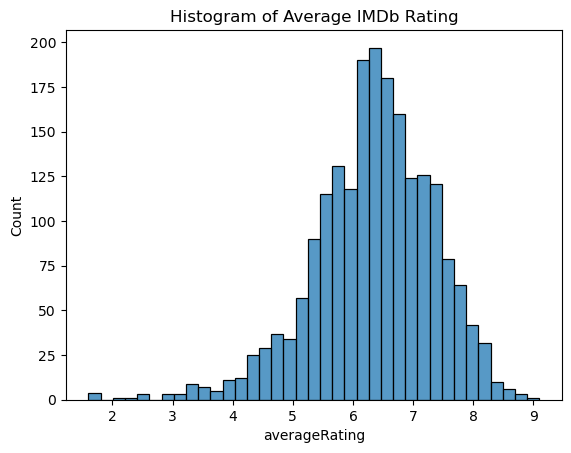

In [ ]:
# Histogram of average IMDb Rating
sns.histplot(df_title_basics_ratings_office_no_duplicates, x='averageRating')
plt.title('Histogram of Average IMDb Rating')
plt.show()

C:\Users\MaxLo\AppData\Local\Temp\ipykernel_4612\491548555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string)
C:\Users\MaxLo\AppData\Local\Temp\ipykernel_4612\491548555.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string, args=',')


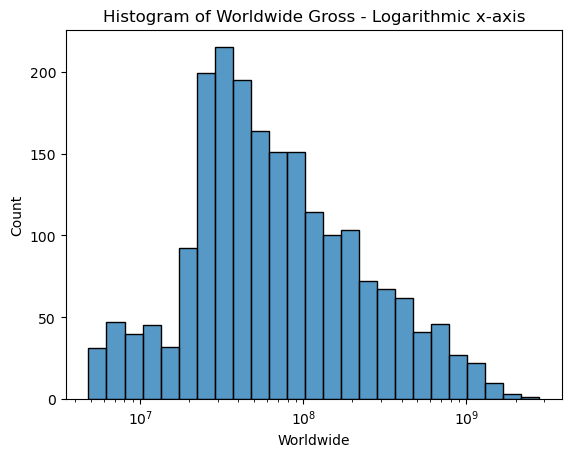

The Worldwide Gross Median is 5.55E+07 and the mean is 1.45E+08


<Axes: xlabel='Worldwide'>

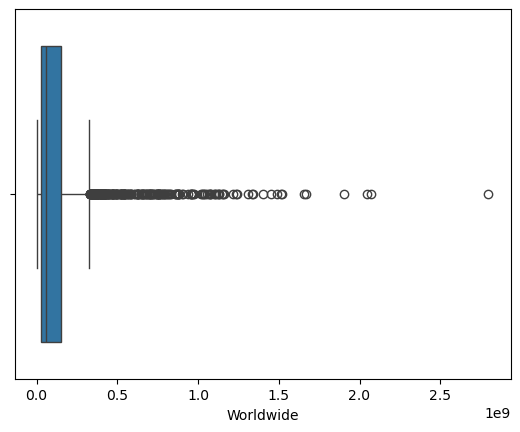

In [ ]:
# Histogram of Worldwide Gross
def replace_string(s, pattern='$'):
    return str(s).replace(pattern, '')

df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string)
df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string, args=',')
df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(int)

sns.histplot(df_title_basics_ratings_office_no_duplicates, x='Worldwide', log_scale=True)
plt.title('Histogram of Worldwide Gross - Logarithmic x-axis')
plt.show()

print(f'The Worldwide Gross Median is {df_title_basics_ratings_office_no_duplicates.Worldwide.median():.2E} and the mean is {df_title_basics_ratings_office_no_duplicates.Worldwide.mean():.2E}')

sns.boxplot(df_title_basics_ratings_office_no_duplicates, x='Worldwide')

The Pearson correlation coefficient is 0.2292269493701698, with p-value 1.3023457122344011e-25


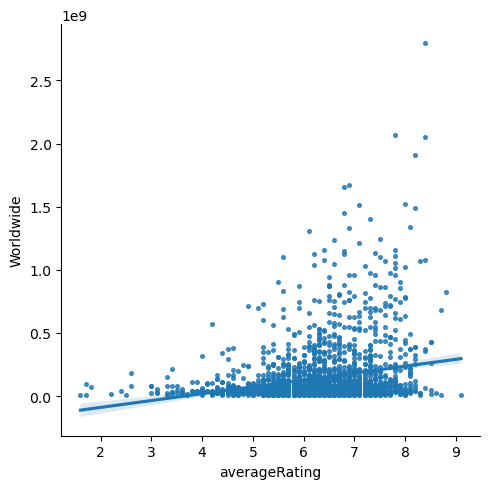

In [ ]:
# Correlation between IMDb Rating and Worldwide Gross
import scipy.stats as ss

corr_Pearson = ss.pearsonr(x=df_title_basics_ratings_office_no_duplicates.averageRating, y=df_title_basics_ratings_office_no_duplicates.Worldwide)
print(f'The Pearson correlation coefficient is {corr_Pearson.statistic}, with p-value {corr_Pearson.pvalue}')

sns.lmplot(df_title_basics_ratings_office_no_duplicates, x='averageRating', y='Worldwide', scatter_kws={'s': 7})

In [ ]:
# High IMDb rating (with both low and high box office)
df_title_basics_ratings_office_no_duplicates.loc[df_title_basics_ratings_office_no_duplicates.averageRating>8.5].head()

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
76,tt0816692,movie,Interstellar,Interstellar,0,2014,\N,169,"Adventure,Drama,Sci-Fi",8.7,2183892,677896797,"$188,020,017",27.70%,"$489,876,780",72.30%
292,tt10811166,movie,The Kashmir Files,The Kashmir Files,0,2022,\N,170,Drama,8.6,575313,24821898,"$1,485,000",6%,"$23,336,898",94%
720,tt1375666,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi",8.8,2607668,826137188,"$292,576,195",35.40%,"$533,560,993",64.60%
1543,tt21093976,movie,National Theatre Live: Prima Facie,National Theatre Live: Prima Facie,0,2022,\N,120,Drama,9.1,2245,6589048,-,-,"$6,589,048",100%
2965,tt7466810,movie,777 Charlie,777 Charlie,0,2022,\N,164,"Adventure,Comedy,Drama",8.7,41742,7523995,-,-,"$7,523,995",100%


In [ ]:
# Low Rating (low box office)
df_title_basics_ratings_office_no_duplicates.loc[df_title_basics_ratings_office_no_duplicates.averageRating<3].sample(5)


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
778,tt14121726,movie,Jeepers Creepers: Reborn,Jeepers Creepers: Reborn,0,2022,\N,88,"Horror,Mystery,Thriller",2.5,15300,5954938,"$2,033,057",34.10%,"$3,921,881",65.90%
2884,tt6910020,movie,Nothing to Lose,Nada a Perder,0,2018,\N,134,"Biography,Drama",2.4,23138,36075317,"$1,016,188",2.80%,"$35,059,129",97.20%
3055,tt8081062,movie,Amazing China,"Li Hai Le, Wo De Guo",0,2018,\N,90,Documentary,1.8,3908,72506343,-,-,"$72,506,343",100%
2563,tt5237980,movie,From Vegas to Macau III,Du cheng feng yun III,0,2016,\N,113,"Comedy,Drama",2.6,3360,181732879,-,-,"$181,732,879",100%
684,tt13486236,movie,Smack Dab Kakha,Neposredstvenno Kakha,0,2020,\N,110,Comedy,1.6,1385,9995945,-,-,"$9,995,945",100%


In [60]:
# Low rating with high box office
df_title_basics_ratings_office_no_duplicates.loc[df_title_basics_ratings_office_no_duplicates.averageRating<6].loc[df_title_basics_ratings_office_no_duplicates.Worldwide>500000000].head()

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
32,tt0472181,movie,The Smurfs,The Smurfs,0,2011,\N,103,"Adventure,Animation,Comedy",5.4,98490,563749323,"$142,614,158",25.30%,"$421,135,165",74.70%
215,tt10370822,movie,Detective Chinatown 3,Tang ren jie tan an 3,0,2021,\N,136,"Action,Adventure,Comedy",5.6,2703,686257563,-,-,"$686,257,563",100%
641,tt1324999,movie,The Twilight Saga: Breaking Dawn - Part 1,The Twilight Saga: Breaking Dawn - Part 1,0,2011,\N,117,"Adventure,Drama,Fantasy",4.9,258303,712205856,"$281,287,133",39.50%,"$430,918,723",60.50%
642,tt1325004,movie,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,0,2010,\N,124,"Action,Adventure,Drama",5.1,265199,698491347,"$300,531,751",43%,"$397,959,596",57%
683,tt13462900,movie,The Battle at Lake Changjin,Chang jin hu,0,2021,\N,176,"Action,Drama,History",5.5,4321,902548476,"$342,411",<0.1%,"$902,206,065",100%
